Please download tiny-imagenet-200 zip file first and run process.sh file on it before running this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import torch
from tqdm import tqdm
from sklearn.manifold import TSNE
from torch.nn import CrossEntropyLoss
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchsummary import summary

torch.manual_seed(422)
torch.cuda.manual_seed(422)

Loading data below

In [2]:
DATA_DIR = 'tiny-imagenet-200'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

data = datasets.ImageFolder(TRAIN_DIR, transform=ToTensor())
test_data = datasets.ImageFolder(VALID_DIR, transform=ToTensor())

class TrainData(Dataset):
    def __init__(self):
        super(TrainData, self).__init__()

    def __getitem__(self, item):
        return data.__getitem__(item)

    def __len__(self):
        return 5000

class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()

    def __getitem__(self, item):
        return test_data.__getitem__(item)

    def __len__(self):
        return 500

dat = TrainData()
test = TestData()

train_loader = DataLoader(dat, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=100)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def accuracy(predicted, true):
    return torch.mean((true==torch.argmax(predicted, dim=1)).type(torch.FloatTensor)).numpy()

# Questions 1
Alexnet first, then resnet.
For both models, we first print model summary (number of model parameters is present in it). Then we print TSNE plots after training on first and last epochs. Then we print training and testing accuracies. Then we print loss plots. Then we visualize activation maps.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

  0%|          | 0/10 [00:00<?, ?it/s]

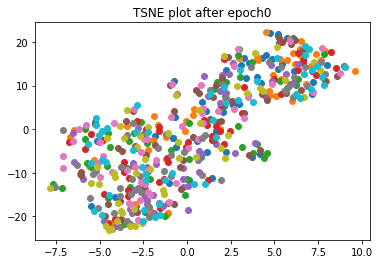

 90%|█████████ | 9/10 [00:46<00:04,  4.96s/it]

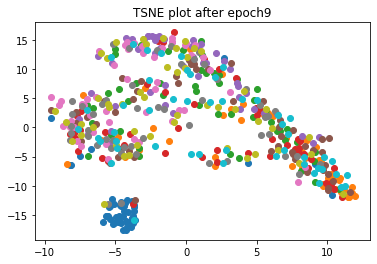

100%|██████████| 10/10 [00:52<00:00,  5.29s/it]


Training accuracy = 0.3060000038146973
Testing accuracy = 0.27999999076128007


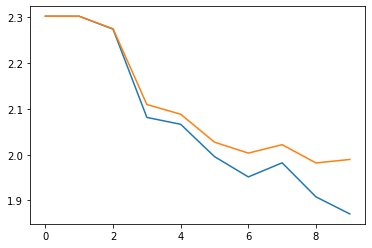

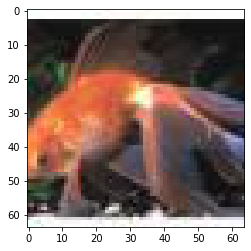

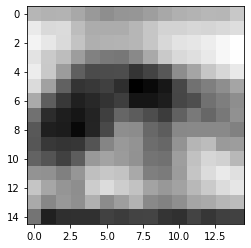

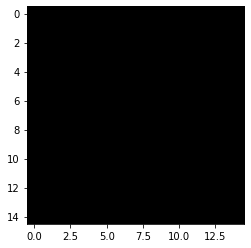

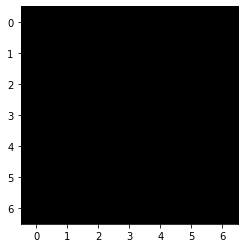

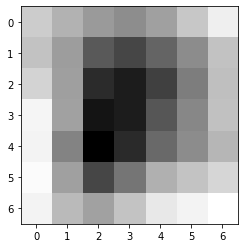

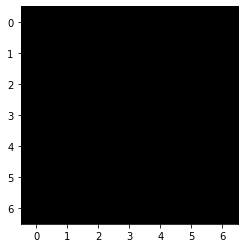

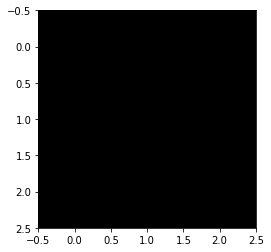

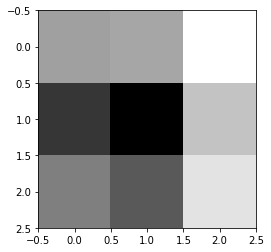

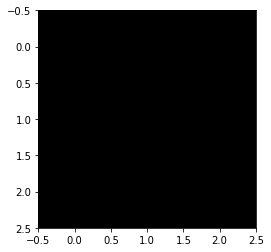

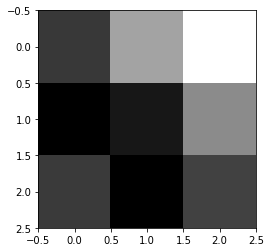

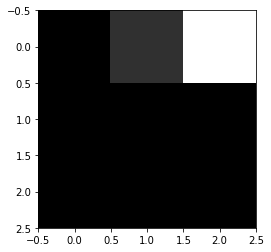

In [5]:
n_epochs = 10
model = models.AlexNet(num_classes=10)
model = model.to(device)
opt = optim.Adam(model.parameters())
loss_func = CrossEntropyLoss()
train_error = []
test_error = []

print(summary(model, (3, 64, 64)))

for i in tqdm(range(n_epochs)):
    model.train()
    for j, (x, y) in enumerate(train_loader):
        opt.zero_grad()
        x, y = x.to(device), y.to(device)
        preds = model(x)
        minibatch_loss = loss_func(preds, y)
        minibatch_loss.backward()
        opt.step()

    model.eval()
    train_loss = 0
    for j, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        train_loss += (loss_func(preds, y)*len(x)).detach()
    train_loss /= 5000
    train_error.append(train_loss)

    test_loss = 0
    for j, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        test_loss += (loss_func(preds, y)*len(x)).detach()
    test_loss /= 500
    test_error.append(test_loss)

    if i == 0 or i == n_epochs-1:
        feats = []
        for j, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            feat = torch.flatten(model.avgpool(model.features(x)), 1).detach().to('cpu').numpy()
            feats.append(feat)
        feats = np.vstack(feats)
        a = TSNE(n_components=2, init='random', perplexity=60, n_iter=1000).fit_transform(feats)
        for p in range(10):
            plt.scatter(a[50*p:50*p+50, 0], a[50*p:50*p+50, 1], marker='o')
        plt.title("TSNE plot after epoch"+str(i))
        plt.show()

train_accuracy = 0
for j, (x, y) in enumerate(train_loader):
    x, y = x.to(device), y.to(device)
    preds = model(x)
    train_accuracy += (accuracy(preds, y)*len(x))
train_accuracy /= 5000
test_accuracy = 0
for j, (x, y) in enumerate(test_loader):
    x, y = x.to(device), y.to(device)
    preds = model(x)
    test_accuracy += (accuracy(preds, y)*len(x))
test_accuracy /= 500

plt.plot(np.arange(n_epochs), train_error)
plt.plot(np.arange(n_epochs), test_error)
print("Training accuracy =", train_accuracy)
print("Testing accuracy =", test_accuracy)
plt.show()

model = model.to('cpu')
img = test.__getitem__(0)
plt.imshow(np.transpose(img[0], (1,2,0)))
plt.show()
img = torch.reshape(img[0], [1, 3, 64, 64])
for i in range(10):
    img = model.features[i](img)
    plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
    plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

  0%|          | 0/10 [00:00<?, ?it/s]

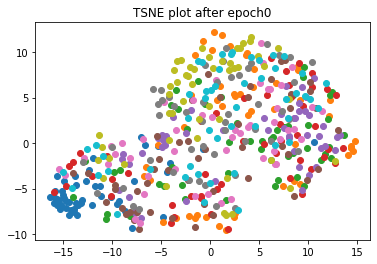

 90%|█████████ | 9/10 [02:10<00:14, 14.34s/it]

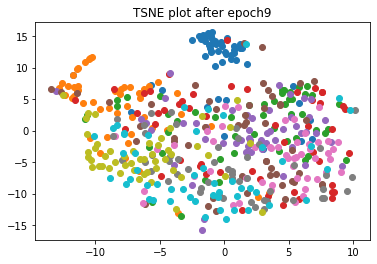

100%|██████████| 10/10 [02:26<00:00, 14.66s/it]


Training accuracy = 0.5616000044345856
Testing accuracy = 0.3579999953508377


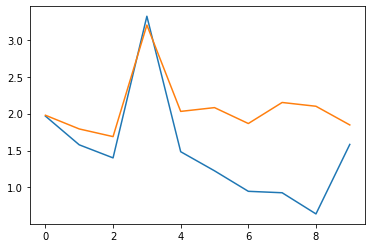

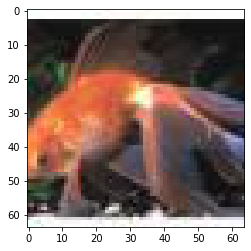

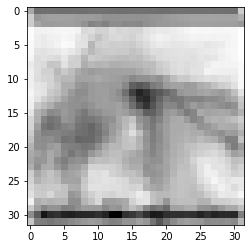

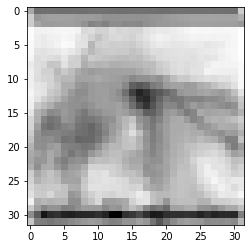

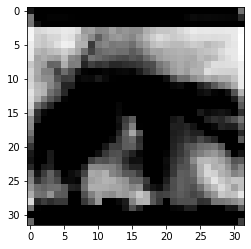

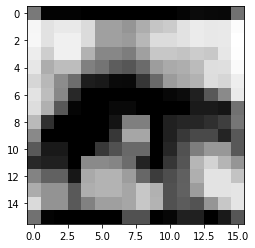

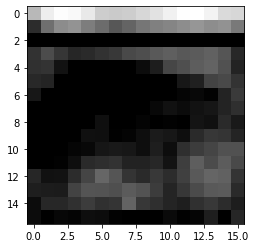

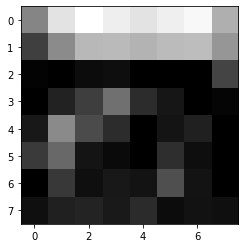

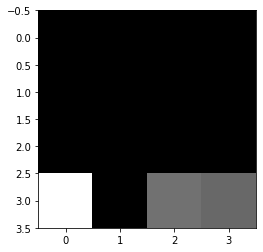

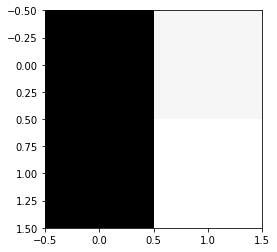

In [6]:
n_epochs = 10
model = models.resnet50(num_classes=10)
model = model.to(device)
opt = optim.Adam(model.parameters())
loss_func = CrossEntropyLoss()
train_error = []
test_error = []

print(summary(model, (3, 64, 64)))

for i in tqdm(range(n_epochs)):
    model.train()
    for j, (x, y) in enumerate(train_loader):
        opt.zero_grad()
        x, y = x.to(device), y.to(device)
        preds = model(x)
        minibatch_loss = loss_func(preds, y)
        minibatch_loss.backward()
        opt.step()

    model.eval()
    train_loss = 0
    for j, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        train_loss += (loss_func(preds, y)*len(x)).detach()
    train_loss /= 5000
    train_error.append(train_loss)

    test_loss = 0
    for j, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        test_loss += (loss_func(preds, y)*len(x)).detach()
    test_loss /= 500
    test_error.append(test_loss)

    if i == 0 or i == n_epochs-1:
        feats = []
        for j, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            feat = torch.flatten(model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.maxpool(model.relu(model.bn1(model.conv1(x))))))))), 1).detach().to('cpu').numpy()
            feats.append(feat)
        feats = np.vstack(feats)
        a = TSNE(n_components=2, init='random', perplexity=60, n_iter=1000).fit_transform(feats)
        for p in range(10):
            plt.scatter(a[50*p:50*p+50, 0], a[50*p:50*p+50, 1], marker='o')
        plt.title("TSNE plot after epoch"+str(i))
        plt.show()

train_accuracy = 0
for j, (x, y) in enumerate(train_loader):
    x, y = x.to(device), y.to(device)
    preds = model(x)
    train_accuracy += (accuracy(preds, y)*len(x))
train_accuracy /= 5000
test_accuracy = 0
for j, (x, y) in enumerate(test_loader):
    x, y = x.to(device), y.to(device)
    preds = model(x)
    test_accuracy += (accuracy(preds, y)*len(x))
test_accuracy /= 500

plt.plot(np.arange(n_epochs), train_error)
plt.plot(np.arange(n_epochs), test_error)
print("Training accuracy =", train_accuracy)
print("Testing accuracy =", test_accuracy)
plt.show()

model = model.to('cpu')
img = test.__getitem__(0)
plt.imshow(np.transpose(img[0], (1,2,0)))
plt.show()
img = torch.reshape(img[0], [1, 3, 64, 64])

img = model.conv1(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

img = model.bn1(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

img = model.relu(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

img = model.maxpool(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

img = model.layer1(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

img = model.layer2(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

img = model.layer3(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

img = model.layer4(img)
plt.imshow(np.transpose(img.detach()[0, :, :, :], (1,2,0))[:, :, 0], cmap='gray')
plt.show()

ResNet performance was much better. The activation maps were also better. Surprisingly, the number of model parameters was also less. However, the training time was thrice that of AlexNet. But since the training time was not very high, I would consider using ResNet for this task. The training was stopped after 10 epoch for both the models as it was observed that the models quickly overfitted after that.

# Question 2
# Part A
Below, we reproduce the results from the tutorial.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/Russian.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Portuguese.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8680, -2.9225, -2.8741, -2.7819, -2.8457, -2.9724, -2.8616, -2.8467,
         -2.9453, -2.9235, -2.9197, -2.9180, -2.8569, -2.9087, -2.8959, -2.8661,
         -2.8661, -2.9735]], grad_fn=<LogSoftmaxBackward0>)


In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 3)


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Bartosz
category = French / line = Denis
category = Chinese / line = Hew
category = Czech / line = Stupka
category = Chinese / line = Zong
category = Italian / line = Ganza
category = Chinese / line = Fei
category = Chinese / line = Chai
category = Korean / line = Kim
category = Polish / line = Gwozdek


In [10]:
criterion = nn.NLLLoss()

In [24]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [25]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.7194 Mcgregor / German ✗ (Scottish)
10000 10% (0m 19s) 2.2912 Puerta / Japanese ✗ (Spanish)
15000 15% (0m 29s) 2.6640 Rory / English ✗ (Irish)
20000 20% (0m 37s) 1.7914 Johnstone / Scottish ✓
25000 25% (0m 46s) 2.4827 Victor / French ✗ (Czech)
30000 30% (0m 55s) 0.7352 Chau / Vietnamese ✓
35000 35% (1m 5s) 1.3104 Phung / Chinese ✗ (Vietnamese)
40000 40% (1m 14s) 1.7500 Wang / Chinese ✗ (Korean)
45000 45% (1m 22s) 1.2431 Cardozo / Portuguese ✓
50000 50% (1m 31s) 1.9131 Von brandt / French ✗ (German)
55000 55% (1m 40s) 0.0866 Wojewodzki / Polish ✓
60000 60% (1m 49s) 1.9485 Bang / Chinese ✗ (Korean)
65000 65% (1m 59s) 1.2182 Faure / French ✓
70000 70% (2m 9s) 2.5240 Rheem / Dutch ✗ (Korean)
75000 75% (2m 20s) 0.7946 Chou / Korean ✓
80000 80% (2m 29s) 2.0944 Kibblewhite / Scottish ✗ (English)
85000 85% (2m 39s) 3.2996 Hass / Arabic ✗ (German)
90000 90% (2m 49s) 1.4937 Gagne / French ✓
95000 95% (2m 58s) 2.0325 Araullo / Italian ✗ (Portuguese)
100000 100% (3m 8s) 1.5142 C

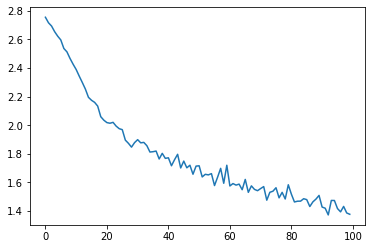

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_41921/3649271960.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_41921/3649271960.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


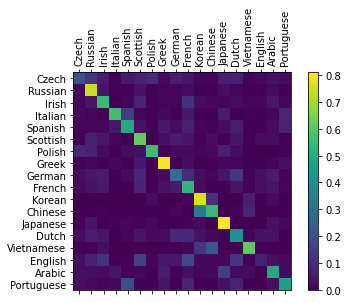

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.44) Russian
(-2.36) Czech
(-2.42) Polish

> Jackson
(-0.52) Scottish
(-1.63) Russian
(-2.44) English

> Satoshi
(-1.40) Japanese
(-1.64) Polish
(-2.39) Portuguese


# Part B
Below we replace the RNN with a GRU and report the classification accuracy.

In [22]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input, hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = GRU(n_letters, n_hidden, n_categories)

In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [31]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

print("Classification accuracy =", (torch.sum(confusion[torch.arange(n_categories), torch.arange(n_categories)])/torch.sum(confusion)).numpy())

Classification accuracy = 0.533


# Part C
Below we replace the GRU with an LSTM and report the classification accuracy.

In [38]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + 2*hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden[0], hidden[1]), 1)
        hidden = self.i2h(input, hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = LSTM(n_letters, n_hidden, n_categories)

In [39]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 2.8448 Sawamatsu / Scottish ✗ (Japanese)
10000 10% (0m 27s) 3.0087 Vass / Greek ✗ (English)
15000 15% (0m 39s) 2.8789 Winfer / German ✗ (English)
20000 20% (0m 51s) 3.2096 Langlais / Greek ✗ (French)
25000 25% (1m 2s) 1.1346 Oyama / Japanese ✓
30000 30% (1m 13s) 1.4368 Leveque / French ✓
35000 35% (1m 26s) 1.4915 Salcedo / Portuguese ✗ (Spanish)
40000 40% (1m 36s) 1.8525 Murphy / English ✗ (Irish)
45000 45% (1m 48s) 1.4919 Klerks / Dutch ✓
50000 50% (2m 1s) 2.8850 Schubert / French ✗ (Czech)
55000 55% (2m 14s) 1.3279 Thian / Vietnamese ✗ (Chinese)
60000 60% (2m 29s) 2.9256 Saliba / Spanish ✗ (Arabic)
65000 65% (2m 43s) 2.0099 Carbone / French ✗ (Italian)
70000 70% (2m 58s) 0.6356 Letsos / Greek ✓
75000 75% (3m 12s) 3.4489 Sarkis / Greek ✗ (Arabic)
80000 80% (3m 26s) 2.7901 Nieddu / Irish ✗ (Italian)
85000 85% (3m 41s) 0.5162 Si / Korean ✓
90000 90% (3m 55s) 0.6017 Veverka / Czech ✓
95000 95% (4m 8s) 0.3844 Slazak / Polish ✓
100000 100% (4m 21s) 2.0898 Curran / Scottish

In [40]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

print("Classification accuracy =", (torch.sum(confusion[torch.arange(n_categories), torch.arange(n_categories)])/torch.sum(confusion)).numpy())

Classification accuracy = 0.5525
